Uses Karplus-Strong algorithm to make some music, as if a guitar were being plucked

In [2]:
import numpy as np
import soundfile as sf

from augment_audio import scale_to_peak_windowed_dBFS

from IPython.display import Audio

In [3]:
import matplotlib.pyplot as plt

In [3]:

damping = 0.99
sr = 16000
def generate(f, vol, nsamples):
    """Generate a Karplus-Strong pluck.
    https://codereview.stackexchange.com/questions/155510/karplus-strong-pluck-generation

    Arguments:
    f -- the frequency, as an integer
    vol -- volume, a float in [0.0, 1.0]
    nsamples -- the number of samples to generate. To generate a pluck t
    seconds long, one needs t * sample_rate samples. nsamples is an int.

    Return value:
    A numpy array of floats with length nsamples.
    """

    N = sr // f
    buf = np.random.rand(N) * 2 - 1
    samples = np.empty(nsamples, dtype=float)

    for i in range(nsamples):
        samples[i] = buf[i % N]
        avg = damping * 0.5 * (buf[i % N] + buf[(1 + i) % N])
        buf[i % N] = avg

    return samples * vol

In [10]:
def play_freq(string, fret):
    """
    1 is the highest pitch string
    """
    base = {1: 329.63, 2: 246.94, 3: 196.00, 4: 146.83, 5: 110.00, 6: 82.41}
    return base[string] * 2**(fret / 12.0)

In [56]:
chord = generate(int(play_freq(3, 6)), 1, int(1.5*16000))
chord += generate(int(play_freq(4, 6)), 1, int(1.5*16000))
chord += generate(int(play_freq(5, 4)), 1, int(1.5*16000))
Audio(chord, rate=sr)

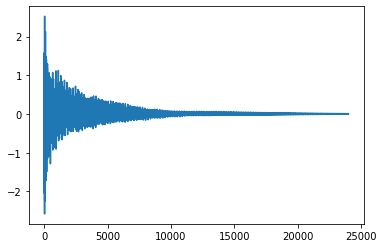

In [8]:
plt.plot(chord)

In [57]:
sf.write('data/nirvana_chord4.wav', chord, 16000)

In [99]:
def play_string(input_str, string_n, dash_length=int(0.10*16000), pluck_len=0):
    sound_out = np.zeros(dash_length*len(input_str))
    for idx, c in enumerate(input_str):
        time = idx * dash_length
        if c in '0123456789ABCDEF':
            freq = play_freq(string_n,int(c, 36))
            pluck = generate(int(freq), 1, int(1.5*16000))
            if pluck_len:
                pluck = pluck[:pluck_len]
            out_len = len(sound_out[time:time+len(pluck)])
            sound_out[time:time+len(pluck)] += pluck[:out_len]

    return scale_to_peak_windowed_dBFS(sound_out, target_dBFS=-15.0, rms_window=5)

In [ ]:
# single string tab converter
# alphabet is like hexadecimal but 1...9,10...36 via 1...9,A...Z

# tabs sourced from: https://tabs.ultimate-guitar.com/tab/misc-children/mary-had-a-little-lamb-tabs-7386

input_str, string_n = '0-0-----0-0--3--5-5-----7-7--3--0-0-----0-0--3--5-5-----7-7--3--', 4 # joan jett, 4 string
input_str, string_n = '7-5-3-5-7-7-7---5-5-5---7-A-A---7-5-3-5-7-7-7---5-5-7-5-3------', 6 # little lamb 6 string
# input_str, string_n = '-979-----', 2 # notification

# nirvana

input_str3, string_n3 = '-----------3-3-0-----------6-6-6' * 2, 3
input_str4, string_n4 = '-3--33-----3-3-0-6--66-----6-6-6' * 2, 4
input_str5, string_n5 = '-3--33-----1-1-0-6--66-----4-4-4' * 2, 5
input_str6, string_n6 = '-1--11-----------4--44----------' * 2, 6
input_strs = [input_str3, input_str4, input_str5, input_str6]
input_ns = [string_n3, string_n4, string_n5, string_n6]

dash_length=int(0.075*16000)
pluck_len = 5824 # when doing adversarial stuff

sound_out = play_string(input_strs[0], input_ns[0], dash_length=dash_length, pluck_len=pluck_len)
for i in range(1,len(input_strs)):
    sound_out += play_string(input_strs[i], input_ns[i], dash_length=dash_length, pluck_len=pluck_len)


In [117]:
Audio(sound_out, rate=sr)

In [118]:
sf.write('data/clean_tnsprt.wav', sound_out[:19680], 16000)

In [43]:
# chunk save
chunk_sz = 5824
n_chunks = len(sound_out) // chunk_sz
for i in range(n_chunks):
    sf.write('data/teen_spirit_{:02d}.wav'.format(i), sound_out[i*chunk_sz:(i+1)*chunk_sz], 16000)

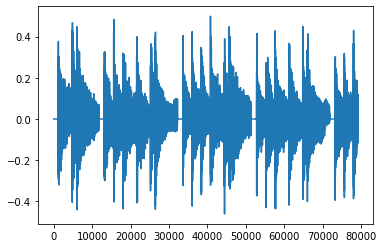

In [112]:
plt.plot(sound_out)

In [62]:
sf.write('data/marry_little_lamb.wav', sound_out, 16000)

In [7]:
def get_bestnoise(npz_name):
    # trials t3 and after had all noises saved
    trial_ = np.load(npz_name)
    acc, i = min(list(zip(trial_['mask_acc'], range(len(trial_['mask_acc']) ) )))
    return acc, trial_['snr'][i], trial_['noise'][i]

In [12]:
# split together chords from files from adversarial training
input_str = '-0--00-----1-1-2-3--33-----4-4-4' *2
input_str = '-0--00-----1-1-2-'

net_type = 'base'
net_i = 1

for net_type in ['base', 'cort']:
    for net_i in range(1,4):
        fname = '/scratch0/ilya/locDownloads/adv_music/{}_net_{}/len31_export/ua_deepfool_0p001_400_nirvanachord{}_t1.npz'
        # fname = '/scratch0/ilya/locDownloads/cortical_music_test/ua_deepfool_0p001_400_nirvanachord{}.npz'
        sound_out = np.zeros(dash_length*len(input_str))
        dash_length=int(0.075*16000)
        for idx, c in enumerate(input_str):
            time = idx * dash_length
            if c in '0123456789':
                c = int(c)
                _,_, pluck = get_bestnoise(fname.format(net_type, net_i, c))
                pluck = pluck[0]
                out_len = len(sound_out[time:time+len(pluck)])
                sound_out[time:time+len(pluck)] += pluck[:out_len]
        #sf.write('data/dirty_{}_{}_t1.wav'.format(net_type, net_i), sound_out[:19680], 16000)

In [13]:
Audio(sound_out[:19680], rate=16000)

In [133]:
sf.write('data/dirty_{}_{}_t1.wav'.format(net_type, net_i), sound_out[:19680], 16000)

In [109]:
Audio(sound_out, rate=sr)

In [130]:
'/scratch0/ilya/locDownloads/adv_music/{}_net_{}/len31_export/ua_deepfool_0p001_400_nirvanachord{}_t1.npz'.format(1, 1,1)

'/scratch0/ilya/locDownloads/adv_music/1_net_1/len31_export/ua_deepfool_0p001_400_nirvanachord1_t1.npz'

In [ ]:
# make matrix
# names of net dirs
bdir = '/scratch0/ilya/locDownloads/adv_music'
netds = ['base_net_1', 'base_net_2', 'base_net_3', 'cort_net_1', 'cort_net_2', 'cort_net_3']
resfs = ['base_1', 'base_2', 'base_3', 'cort_1', 'cort_2', 'cort_3'] # names of result files

for net_i in range(6):
    baseline
    for net_j in ra